In [69]:
import numpy as np
import matplotlib.pyplot as plt

In [70]:
# 2 Variant
f_0 = 10 * 10**6 # МГц -> Гц
T = 5 * 10**(-6) # мкс -> c
q = 4
A = 1
epsilon = 0.9

N = 24
SNRdBMAX = 12
Nerrmax = 50

dt = 1 / (f_0 * N)
t = np.arange(0, T, dt)

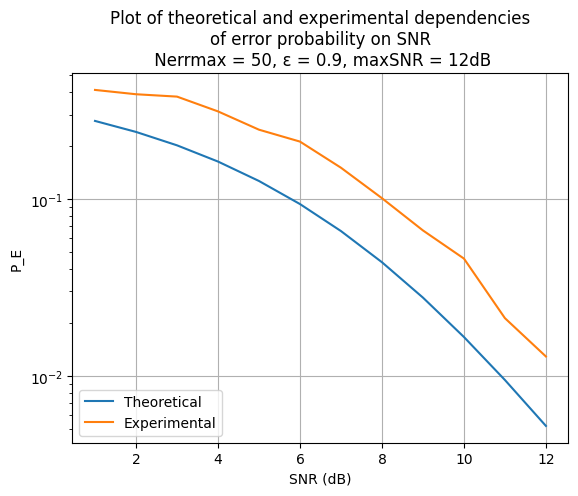

In [80]:
s = np.zeros((q, len(t)))
phi_i_sin = np.zeros((q, len(t)))
phi_i_cos = np.zeros((q, len(t)))
s_i_sin = np.zeros((q, len(t)))
s_i_cos = np.zeros((q, len(t)))

f_i = f_0

for i in range(q):
    f_i = f_0 + (i - 1) / T
    arg = 2 * np.pi * f_i * t
    s[i, :] = A * np.cos(arg)
    phi_i_sin[i] = np.sqrt(2/T) * np.sin(arg)
    phi_i_cos[i] = np.sqrt(2/T) * np.cos(arg)
    s_i_sin[i, :] = A * np.sin(arg)
    s_i_cos[i, :] = A * np.cos(arg)


SNRdB = np.arange(1, SNRdBMAX + 1, 1)
Pe = np.zeros(len(SNRdB))
Pe_t = np.zeros(len(SNRdB))

# Энергия сигнала
E = np.sum(np.square(s), axis=0) / q


for n in range(len(SNRdB)):
    # Отношение сигнал/шум
    SNR = 10**(SNRdB[n] / 10)
    # Значение дисперсии отсчёта шума
    sigma = np.sqrt(np.sum(E / (2 * SNR)))
    Nerr = 0
    Ntest = 0
    
    # Моделирование передатчика и канала
    while Nerr < Nerrmax:
        i = np.random.randint(0, q)  # Случайный выбор сигнала
        theta = 2 * np.pi * np.random.rand()  # Случайная фаза

        math_exp = np.sqrt(epsilon / 2)
        variance = (1 - epsilon) / 2

        x = np.random.normal(math_exp, np.sqrt(variance))
        y = np.random.normal(math_exp, np.sqrt(variance))
        mu = np.sqrt(np.sum(np.square(x) + np.sum(np.square(y), axis=0)))
        
        r = (mu * np.cos(theta)) * s_i_cos[i, :] + (mu * np.sin(theta)) * s_i_sin[i, :] + sigma * np.random.randn(1, len(s[i, :]))
        r_ci = np.zeros((q, Nerrmax))
        r_si = np.zeros((q, Nerrmax))
    
        # Считаем значения для каждого сигнала
        for j in range(q):
            r_ci[j, :] = np.trapz(r * phi_i_cos[j, :], t)
            r_si[j, :] = np.trapz(r * phi_i_sin[j, :], t)  # Значение r_si
            
        # Формирование ^i по правилу
        i_hat = np.argmax((np.power(r_ci, 2) + np.power(r_si, 2)))

        # print(f'i_hat = {i_hat}, i = {i}')
        # Фиксация результата
        if (i_hat // Nerrmax) != i:
            Nerr += 1

        Ntest += 1

    # Экспериментальная оценка вероятности ошибки
    Pe[n] = Nerr / Ntest
    # Вычисление следующего значения SNR
    SNR = 10**((n+1) / 10)  
    N0 = (E / SNR)

    # Теоретическая оценка вероятности ошибки
    Pe_t[n] = (1 / (2 + (1 - epsilon) * E[n] / N0[n])) * np.exp(- (epsilon * E[n] / N0[n]) / (2 + (1 - epsilon) * E[n] / N0[n]))


plt.figure()
plt.semilogy(SNRdB, Pe_t)
plt.semilogy(SNRdB, Pe)
plt.legend(['Theoretical', 'Experimental'], loc='lower left')
plt.title(f'Plot of theoretical and experimental dependencies\nof error probability on SNR\n Nerrmax = {Nerrmax}, ε = {epsilon}, maxSNR = {SNRdBMAX}dB')
plt.xlabel('SNR (dB)')
plt.ylabel('P_E')
plt.grid(True)
plt.show()